# Generate 2D Data

Notebook to generate 2D data for active learning paper

In [4]:
import numpy as np
import dask.array as da

from pymks import (
    generate_multiphase,
    plot_microstructures,
    solve_fe
)

## Generate Data Functions

Functions to generate the microstructure. The microstructures are stochastically generated from 6 nominal classes.

In [5]:
def shuffle(data, chunk_size):
    tmp = np.array(data)
    np.random.shuffle(tmp)
    return da.from_array(tmp, chunks=(chunk_size,) + tmp.shape[1:])

def generate_x(shape, n_sample, seed, max_size=20, chunk_size=100):
    da.random.seed(seed)
    np.random.seed(seed)

    tmp = [
        generate_multiphase(shape=(1,) + shape, grain_size=x, volume_fraction=(0.5, 0.5), chunks=1, percent_variance=0.15)
        for x in np.random.randint(2, 20, size=(n_sample, 2))
    ]
    
    return shuffle(da.concatenate(tmp), chunk_size)


def oracle_from_data(x_data):
    y_stress = solve_fe(x_data,
                        elastic_modulus=(1.3, 2.5),
                        poissons_ratio=(0.42, 0.35),
                        macro_strain=0.001)['stress'][..., 0]

    return np.array(da.average(y_stress.reshape(y_stress.shape[0], -1), axis=1))

## Generate the data

In [8]:
grid_shape = (101, 101)
n_samples = 100
x_data = generate_x(grid_shape, n_samples, 5, chunk_size=100)

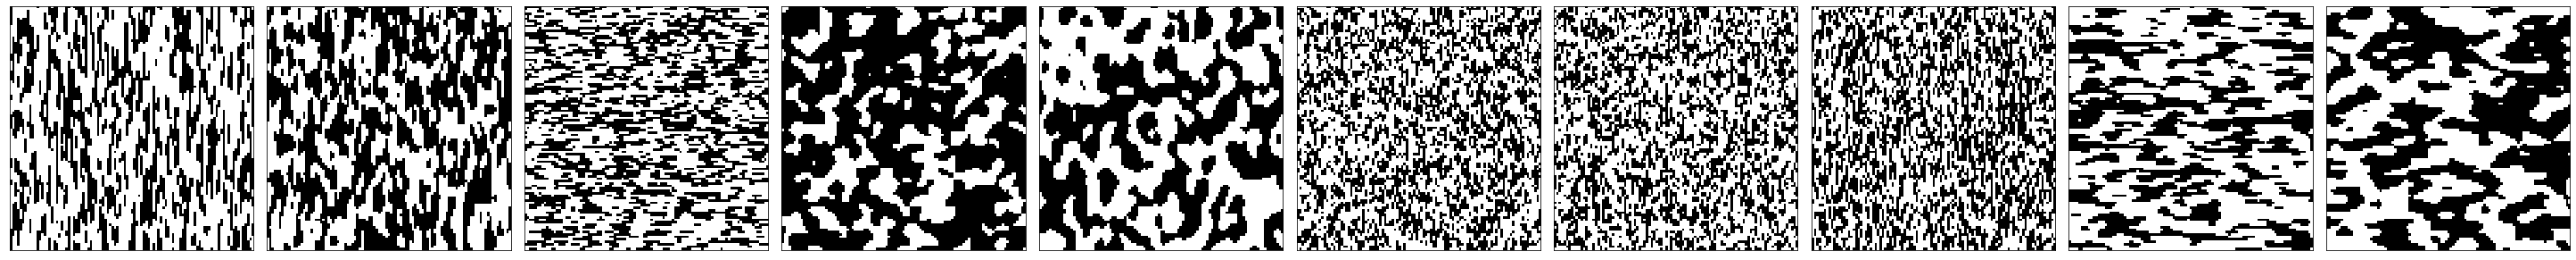

In [9]:
plot_microstructures(*x_data[:10], cmap='gray', colorbar=False);

In [10]:
import time
t0 = time.time()
print(time.strftime('%l:%M%p %z on %b %d, %Y'))
y_data = oracle_from_data(x_data)
print(time.time() - t0)

1694.2340939044952


2.5 minutes for 10 samples
28.2 minutes for 100 samples

In [11]:
np.savez_compressed('data.npz', x_data=np.array(x_data), y_data=np.array(y_data))